In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('png')
%matplotlib inline
import numpy as np
import utils_notebook as un

import importlib
importlib.reload(un)

from fink_filters.filter_mm_module.filter import f_grb_bronze_events, f_grb_silver_events, f_grb_gold_events, f_gw_bronze_events

## Load data

In [3]:
fink_mm_data_path = "/user/julien.peloton/fink_mm/"

grb_obs = ["Fermi", "SWIFT", "INTEGRAL", "ICECUBE"]

In [4]:
gcn = spark.read\
.option("basePath", fink_mm_data_path)\
.option('mergeSchema', True)\
.format("parquet")\
.load([fink_mm_data_path + "gcn_storage/raw"]).toPandas()
gcn = gcn.sort_values("triggerTimejd")
gcn = gcn[gcn["observatory"].isin(grb_obs)]

# Online

In [5]:
fink_mm_online_path = fink_mm_data_path + "gcn_x_ztf/online"
l1 = [fink_mm_online_path + "/year=2023/month=08/day={:02d}".format(i) for i in range(1, 13) if i not in [7, 11]]
l2 = [fink_mm_online_path + f"/year=2023/month=08/day={i}" for i in range(22, 31)]

In [6]:
fink_mm_online_path = fink_mm_data_path + "gcn_x_ztf/online"
ztf_online = spark.read\
.option("basePath", fink_mm_online_path)\
.option('mergeSchema', True)\
.format("parquet")\
.load([fink_mm_online_path]
).toPandas()

In [7]:
ztf_online.columns

Index(['objectId', 'candid', 'ztf_ra', 'ztf_dec', 'fid', 'jdstarthist', 'rb',
       'jd', 'instrument', 'event', 'observatory', 'triggerId', 'gcn_status',
       'gcn_ra', 'gcn_dec', 'gcn_loc_error', 'triggerTimeUTC', 'p_assoc',
       'fink_class', 'raw_event', 'cdsxmatch', 'DR3Name', 'Plx', 'e_Plx',
       'gcvs', 'vsx', 'x3hsp', 'x4lac', 'mangrove', 'roid', 'rf_snia_vs_nonia',
       'snn_snia_vs_nonia', 'snn_sn_vs_all', 'mulens', 'nalerthist',
       'rf_kn_vs_nonkn', 't2', 'anomaly_score', 'lc_features_g',
       'lc_features_r', 'delta_mag', 'rate', 'from_upper', 'start_vartime',
       'diff_vartime', 'timestamp', 'year', 'month', 'day'],
      dtype='object')

In [8]:
merge_online = gcn.merge(ztf_online, on = "triggerId")

In [9]:
merge_online["fink_class"].unique()

array([], dtype=object)

In [10]:
print("Nb events with ztf counterparts: {}".format(len(merge_online["triggerId"].unique())))

Nb events with ztf counterparts: 0


In [11]:
merge_online.groupby(["observatory_x", "instrument_x", "triggerTimeUTC_x", "triggerId"]).agg(
    nb_ztf_alert=("objectId", len),
    unique_class=("fink_class", "unique")
)

,,,,nb_ztf_alert,unique_class
observatory_x,instrument_x,triggerTimeUTC_x,triggerId,,


In [12]:
gcn[gcn["triggerId"] == "714809315"]

,observatory,instrument,event,ivorn,triggerId,ra,dec,err_arcmin,ackTime,triggerTimejd,triggerTimeUTC,raw_event,gcn_status,year,month,day
1605,Fermi,GBM,,ivo://nasa.gsfc.gcn/Fermi#GBM_Fin_Pos2023-08-2...,714809315,299.32,56.47,130.2,2023-08-27 11:04:28.805957,2.460184e+06,2023-08-27 08:08:30.730,"<VOEvent xmlns:xsi=""http://www.w3.org/2001/XML...",None,2023,8,27


## On sky distribution

In [231]:
merge_online.columns

Index(['observatory_x', 'instrument_x', 'event_x', 'ivorn', 'triggerId', 'ra',
       'dec', 'err_arcmin', 'ackTime', 'triggerTimejd', 'triggerTimeUTC_x',
       'raw_event', 'year_x', 'month_x', 'day_x', 'objectId', 'candid',
       'ztf_ra', 'ztf_dec', 'fid', 'jdstarthist', 'rb', 'jd', 'instrument_y',
       'event_y', 'observatory_y', 'gcn_ra', 'gcn_dec', 'gcn_loc_error',
       'triggerTimeUTC_y', 'p_assoc', 'fink_class', 'cdsxmatch', 'DR3Name',
       'Plx', 'e_Plx', 'gcvs', 'vsx', 'x3hsp', 'x4lac', 'mangrove', 'roid',
       'rf_snia_vs_nonia', 'snn_snia_vs_nonia', 'snn_sn_vs_all', 'mulens',
       'nalerthist', 'rf_kn_vs_nonkn', 't2', 'anomaly_score', 'lc_features_g',
       'lc_features_r', 'delta_mag', 'rate', 'from_upper', 'start_vartime',
       'diff_vartime', 'timestamp', 'year_y', 'month_y', 'day_y'],
      dtype='object')

In [232]:
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u

import numpy as np

In [233]:
uniqueGRB = merge_online.drop_duplicates("triggerId")

In [234]:
uniqueGRB.observatory_x.unique()

array(['Fermi'], dtype=object)

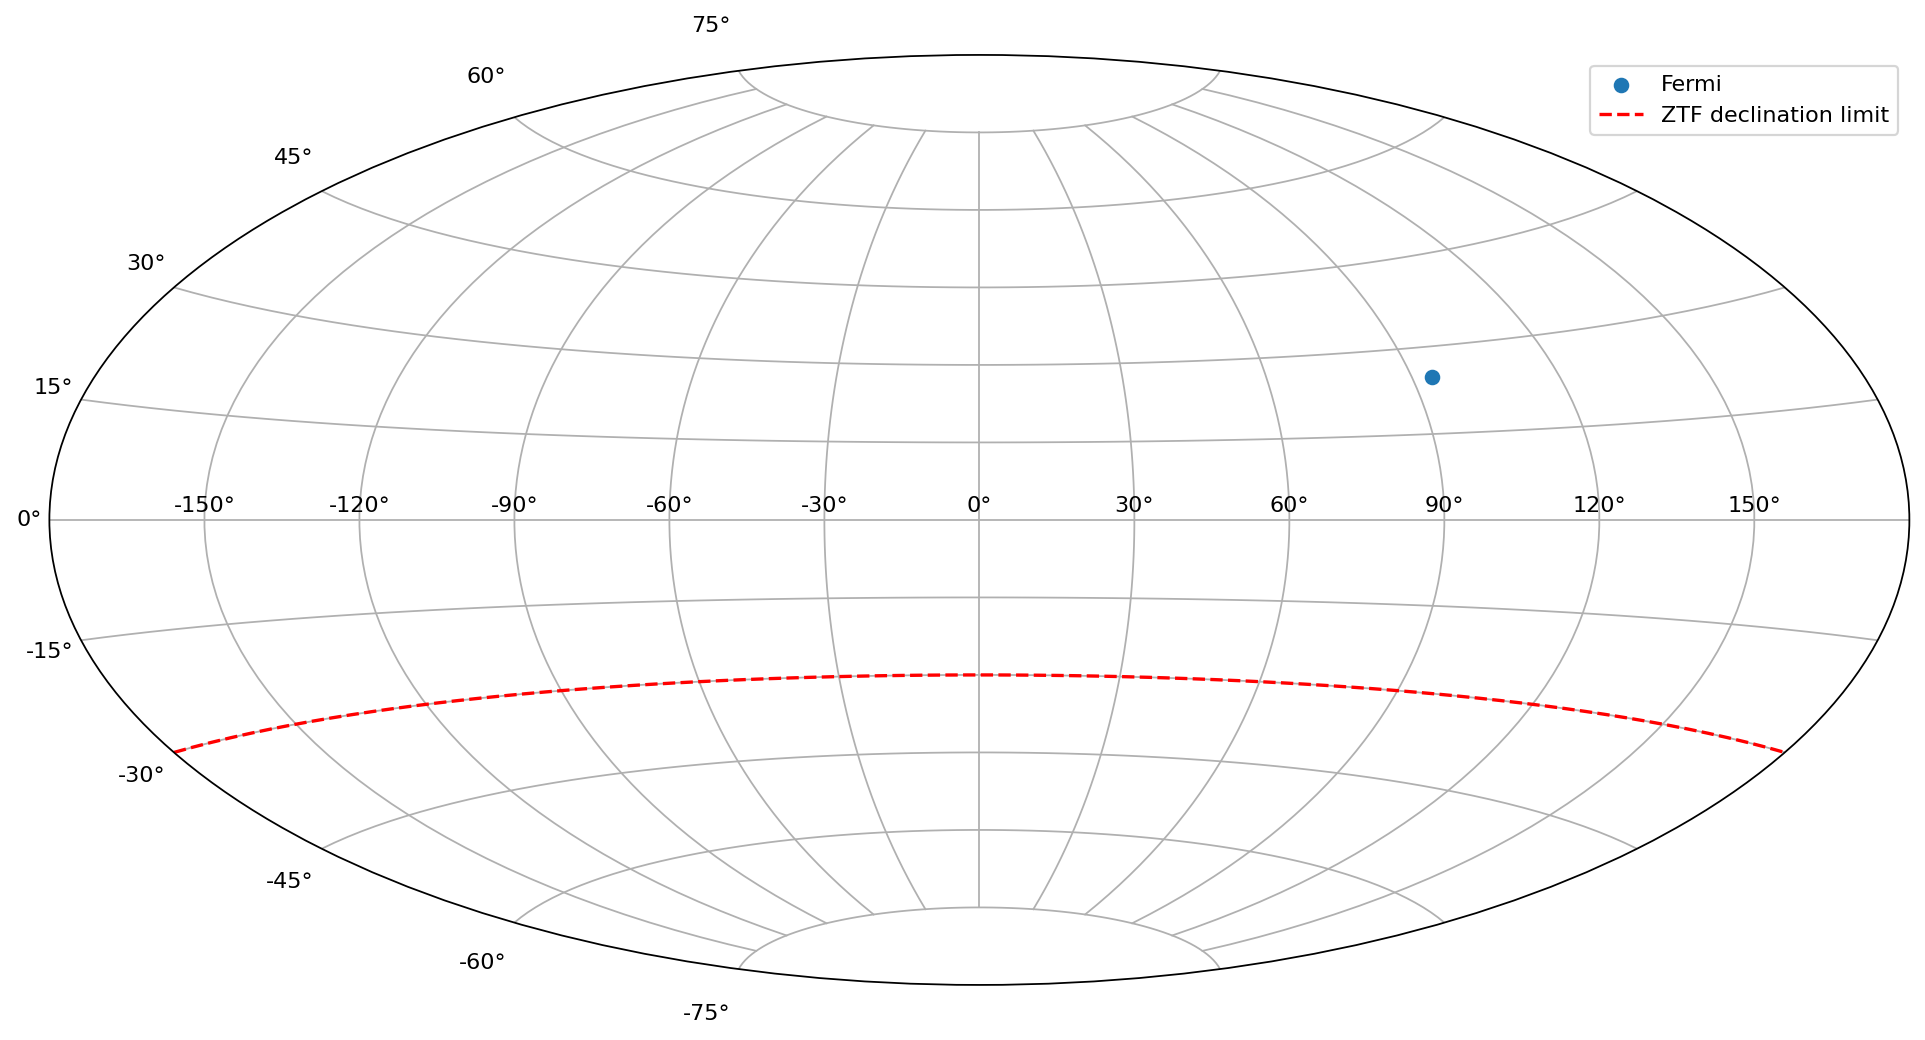

In [235]:
plt.figure(figsize=(15, 15), dpi=160)
plt.subplot(111, projection='aitoff')
plt.grid(True)
for obs in uniqueGRB.observatory_x.unique():
    tmp_pdf = uniqueGRB[uniqueGRB["observatory_x"] == obs]
    if "grb_ra" in tmp_pdf:
        ra, dec = tmp_pdf.grb_ra, tmp_pdf.grb_dec
    else:
        ra, dec = tmp_pdf.gcn_ra, tmp_pdf.gcn_dec
    eq = SkyCoord(ra, dec, unit=u.deg)
    gal = eq.galactic
    
    plt.scatter(gal.l.wrap_at('180d').radian, gal.b.radian, label=obs)
    plt.axhline(y=np.radians(-30), color='r', linestyle='--', label="ZTF declination limit")
    plt.legend()
    plt.show()

## Event analysis

In [236]:
merge_online[merge_online["grb_dec"].notna()][["ra", "dec", "grb_ra", "grb_dec", "ztf_ra", "ztf_dec", "grb_loc_error"]]

KeyError: 'grb_dec'

In [237]:
merge_online[~merge_online["grb_dec"].notna()][["ra", "dec", "grb_ra", "grb_dec", "ztf_ra", "ztf_dec", "grb_loc_error"]]

KeyError: 'grb_dec'

In [238]:
eventId = "714809315"

In [240]:
merge_online[merge_online["ra"] != merge_online["gcn_ra"]][
    [
        "observatory_x", 
        "triggerId",
        "triggerTimeUTC_x",
        "ra", "dec", "gcn_ra", 
        "gcn_dec", "ztf_ra", 
        "ztf_dec", "gcn_loc_error"
    ]
].drop_duplicates("triggerId")

,observatory_x,triggerId,triggerTimeUTC_x,ra,dec,gcn_ra,gcn_dec,ztf_ra,ztf_dec,gcn_loc_error
0,Fermi,714809315,2023-08-27 08:08:30.730,299.32,56.47,281.5333,64.0,287.361224,67.844492,310.998


In [241]:
merge_online[["observatory_x","triggerTimeUTC_x","ra", "dec", "gcn_ra", "gcn_dec", "ztf_ra", "ztf_dec", "gcn_loc_error"]]

,observatory_x,triggerTimeUTC_x,ra,dec,gcn_ra,gcn_dec,ztf_ra,ztf_dec,gcn_loc_error
0,Fermi,2023-08-27 08:08:30.730,299.32,56.47,281.5333,64.0,287.361224,67.844492,310.998
1,Fermi,2023-08-27 08:08:30.730,299.32,56.47,281.5333,64.0,293.737467,64.498422,310.998
2,Fermi,2023-08-27 08:08:30.730,299.32,56.47,281.5333,64.0,287.922924,65.535274,310.998
3,Fermi,2023-08-27 08:08:30.730,299.32,56.47,281.5333,64.0,290.338515,64.368910,310.998
4,Fermi,2023-08-27 08:08:30.730,299.32,56.47,281.5333,64.0,291.325684,67.731091,310.998
5,Fermi,2023-08-27 08:08:30.730,299.32,56.47,281.5333,64.0,285.942097,69.111354,310.998


In [196]:
merge_online[merge_online["triggerId"] == eventId].columns

Index(['observatory_x', 'instrument_x', 'event_x', 'ivorn', 'triggerId', 'ra',
       'dec', 'err_arcmin', 'ackTime', 'triggerTimejd', 'triggerTimeUTC_x',
       'raw_event', 'year_x', 'month_x', 'day_x', 'objectId', 'candid',
       'ztf_ra', 'ztf_dec', 'fid', 'jdstarthist', 'rb', 'jd', 'instrument_y',
       'event_y', 'observatory_y', 'gcn_ra', 'gcn_dec', 'gcn_loc_error',
       'triggerTimeUTC_y', 'p_assoc', 'fink_class', 'cdsxmatch', 'DR3Name',
       'Plx', 'e_Plx', 'gcvs', 'vsx', 'x3hsp', 'x4lac', 'mangrove', 'roid',
       'rf_snia_vs_nonia', 'snn_snia_vs_nonia', 'snn_sn_vs_all', 'mulens',
       'nalerthist', 'rf_kn_vs_nonkn', 't2', 'anomaly_score', 'lc_features_g',
       'lc_features_r', 'delta_mag', 'rate', 'from_upper', 'start_vartime',
       'diff_vartime', 'timestamp', 'year_y', 'month_y', 'day_y'],
      dtype='object')

In [217]:
a = merge_online[merge_online["triggerId"] == eventId][["triggerTimeUTC_x","ra", "dec", "gcn_ra", "gcn_dec", "ztf_ra", "ztf_dec", "gcn_loc_error"]]
a["gcn_loc_error"] = a["gcn_loc_error"] / 60
a

KeyError: "['gcn_ra', 'gcn_dec', 'gcn_loc_error'] not in index"

In [88]:
event_pdf = merge_online[merge_online["triggerId"] == eventId].rename({
    "observatory_x": "observatory"
}, axis=1)

In [163]:
afterglow_coord = SkyCoord(299.639757, 54.463354, unit="deg")
gcn_coord_false = SkyCoord(a["gcn_ra"], a["gcn_dec"], unit="deg")
gcn_coord_true = SkyCoord(a["ra"], a["dec"], unit="deg")
afterglow_coord.separation(gcn_coord_true).deg

array([2.01481034, 2.01481034, 2.01481034, 2.01481034, 2.01481034,
       2.01481034])

In [155]:
event_pdf["objectId"]

0    ZTF23ababzuh
1    ZTF23abacbey
2    ZTF23ababznn
3    ZTF23ababyve
4    ZTF23abacace
5    ZTF23ababzrt
Name: objectId, dtype: object

fink class for this event: ['Solar System candidate' 'Unknown']


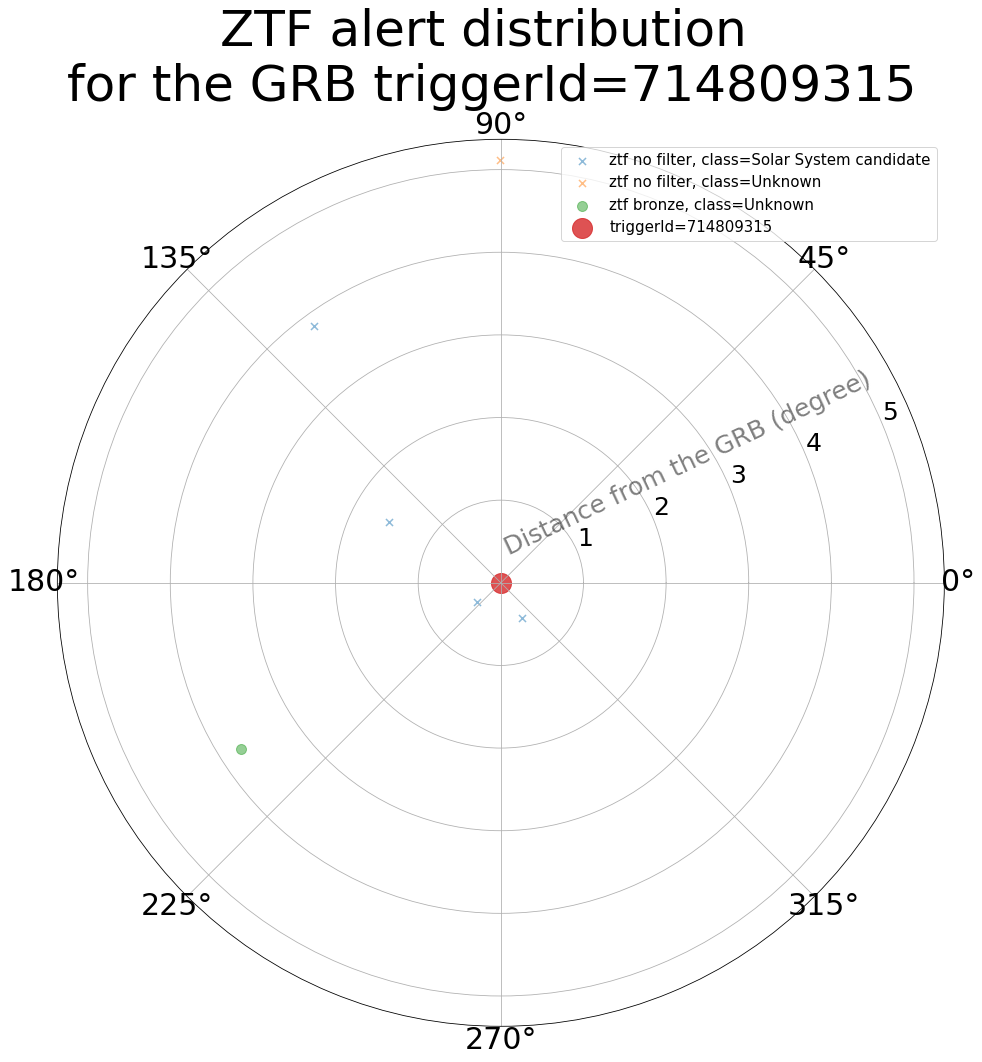

In [92]:
un.plot_ztf_join_distribution(event_pdf, eventId, True)

In [17]:
gold, silver = un.get_gold_and_silver(event_pdf)

In [18]:
gold

,observatory_x,instrument_x,event_x,ivorn,triggerId,ra,dec,err_arcmin,ackTime,triggerTimejd,...,fink_class,delta_mag,rate,from_upper,start_vartime,diff_vartime,timestamp,year_y,month_y,day_y
